# Import Libraries

In [1]:
import numpy as np
import pandas as pd

# import math
import matplotlib.pyplot as plt
import os
from aeon.utils.numba.general import z_normalise_series_2d
from aeon.distances import get_distance_function
import time

In [2]:
# %load_ext autoreload
# %autoreload 2
from ksfdtw.distance_measures import (
    psdtw_prime_vanilla as psdtw_prime_vanilla,
    psdtw_prime_lb_shen as psdtw_prime_lb_shen,
    cut_based_distance as cut_based_distance,
)
from ksfdtw.utils import precision_at_k

# Import Dataset

In [ ]:
dataset_name = "CBF"
P = 3
l = 1.5
data = np.load(
    f"../data_processed/{dataset_name}_P{P}_uniform.npz",
    allow_pickle=True,
)
# Use Train or Test set?
trans_uniform_concatenated = data["X_train_trans_uniform_concatenated"]
# trans_uniform_concatenated = data["X_test_trans_uniform_concatenated"]

data = np.load(
    f"../data_processed/{dataset_name}_P{P}_l{l:.2f}_random.npz",
    allow_pickle=True,
)
# Use Train or Test set?
trans_random_concatenated = data["X_train_trans_random_concatenated"]
# trans_random_concatenated = data["X_test_trans_random_concatenated"]

## Z-normalise the transformed series

In [4]:
trans_uniform_concatenated = z_normalise_series_2d(trans_uniform_concatenated)
trans_random_concatenated = z_normalise_series_2d(trans_random_concatenated)
instance_idx = 0

## Plot graph

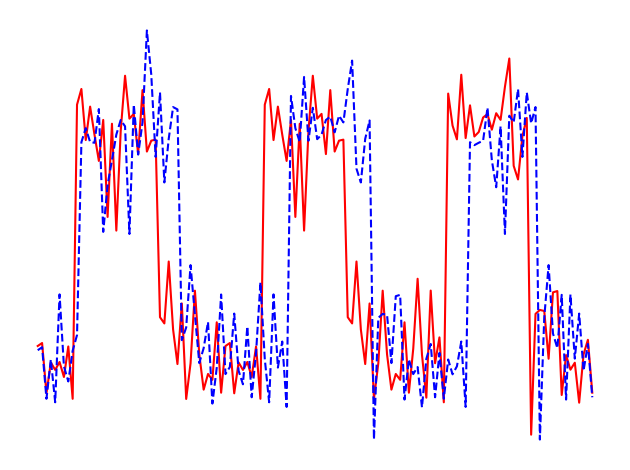

128

In [5]:
plt.plot(trans_uniform_concatenated[instance_idx], color="red")
plt.plot(trans_random_concatenated[instance_idx], color="blue", linestyle="--")
plt.axis("off")
plt.tight_layout()
# plt.savefig("../figures/concatenation_uniform_vs_random.pdf", format="pdf", bbox_inches="tight")
plt.show()
len(trans_uniform_concatenated[instance_idx])

## Assign query and target sets

In [6]:
# Query set
query_set = trans_random_concatenated

# Target set
target_set = trans_uniform_concatenated
if len(query_set) != len(target_set):
    raise ValueError("query_set and target_set have different sizes!")

# Searching with distance measures provided in aeon

## Precision@k

Compute $P@k$ for querying $Q \in$ `query_set` using `method_name` on `target_set`

In [7]:
# https://www.aeon-toolkit.org/en/latest/api_reference/distances.html
# https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.distances.get_distance_function.html
dist_funcs = {
    "squared": get_distance_function("squared"),  # ED
    "dtw": lambda Q, C: get_distance_function("dtw")(Q, C, window=0.1),
    "adtw": lambda Q, C: get_distance_function("adtw")(Q, C, window=0.1),
    "ddtw": lambda Q, C: get_distance_function("ddtw")(Q, C, window=0.1),
    # "erp": lambda Q, C: get_distance_function("erp")(Q, C, window=0.1),
    # "edr": lambda Q, C: get_distance_function("edr")(Q, C, window=0.1),
    # "lcss": lambda Q, C: get_distance_function("lcss")(Q, C, window=0.1),
    # "manhattan": get_distance_function("manhattan"),
    # "minkowski": get_distance_function("minkowski"),
    # "msm": lambda Q, C: get_distance_function("msm")(Q, C, window=0.1),
    # "sbd": get_distance_function("sbd"),
    "shape_dtw": lambda Q, C: get_distance_function("shape_dtw")(Q, C, window=0.1),
    # "twe": lambda Q, C: get_distance_function("twe")(Q, C, window=0.1),
    "wddtw": lambda Q, C: get_distance_function("wddtw")(Q, C, window=0.1),
    "wdtw": lambda Q, C: get_distance_function("wdtw")(Q, C, window=0.1),
}

In [8]:
for dist_name, dist_func in dist_funcs.items():
    start = time.time()
    precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
    for i in range(0, len(query_set)):
        distances = np.array([dist_func(query_set[i], x) for x in target_set])

        precision_at_1 += precision_at_k(distances, i, 1)
        precision_at_3 += precision_at_k(distances, i, 3)
        precision_at_5 += precision_at_k(distances, i, 5)
        precision_at_7 += precision_at_k(distances, i, 7)
    # print(
    #     f"{precision_at_1 / len(query_set):.2f}",
    #     f"{precision_at_3 / len(query_set):.2f}",
    #     f"{precision_at_5 / len(query_set):.2f}",
    #     f"{precision_at_7 / len(query_set):.2f}",
    # )
    print(
        f"{precision_at_1 / len(query_set):.2f} & {precision_at_3 / len(query_set):.2f}",
        end=" & ",
    )
    end = time.time()
    elapsed_time = end - start
    # print("Elapsed time for overall distance computation: " + str(elapsed_time))

0.53 & 0.67 & 0.83 & 1.00 & 0.90 & 1.00 & 0.73 & 0.87 & 0.73 & 0.90 & 0.77 & 0.90 & 0.90 & 1.00 & 

# Searching with PSED, PSDTW

In [9]:
dist_method = 0  # 0 for PSED, 1 for PSDTW
vanilla = True  # True for vanilla, False for lb_shen
if vanilla:
    dist_func_pp = lambda Q, C: psdtw_prime_vanilla(
        Q, C, l=l, P=P, r=0.1, dist_method=dist_method
    )
else:
    dist_func_pp = lambda Q, C: psdtw_prime_lb_shen(
        Q, C, l=l, P=P, r=0.1, dist_method=dist_method
    )

dist_func_p = lambda Q, C: dist_func_pp(Q, C)
# new_len = 150
# dist_func_p = lambda Q, C: dist_func_pp(
#     nearest_neighbor_interpolation(Q, new_len),
#     nearest_neighbor_interpolation(C, new_len),
# )

## Warmup for numba

In [10]:
def dist_func(Q, C):
    dist, _, _ = dist_func_p(Q, C)
    return dist

In [11]:
dist_func(
    trans_uniform_concatenated[instance_idx],
    trans_random_concatenated[instance_idx],
)
start = time.time()
dist_func(
    trans_uniform_concatenated[instance_idx],
    trans_random_concatenated[instance_idx],
)
end = time.time()
elapsed_time = end - start
print("Elapsed time for a single distance computation: " + str(elapsed_time))

Elapsed time for a single distance computation: 0.05302023887634277


In [12]:
len(trans_uniform_concatenated[instance_idx])

128

## Precision@k

In [13]:
all_distances = []
all_count_dist_calls = []
all_cuts = []
start = time.time()
precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
for i in range(0, len(query_set)):
    results = [dist_func_p(query_set[i], x) for x in target_set]
    dist_arr, count_dist_calls_arr, cuts_arr = zip(*results)
    distances = np.array(dist_arr)

    # store per-iteration results
    all_distances.append(distances)
    all_count_dist_calls.append(count_dist_calls_arr)
    all_cuts.append(cuts_arr)

    precision_at_1 += precision_at_k(distances, i, 1)
    precision_at_3 += precision_at_k(distances, i, 3)
    precision_at_5 += precision_at_k(distances, i, 5)
    precision_at_7 += precision_at_k(distances, i, 7)
# print(
#     f"{precision_at_1 / len(query_set):.2f}",
#     f"{precision_at_3 / len(query_set):.2f}",
#     f"{precision_at_5 / len(query_set):.2f}",
#     f"{precision_at_7 / len(query_set):.2f}",
# )
print(
    f"{precision_at_1 / len(query_set):.2f} & {precision_at_3 / len(query_set):.2f}",
    end=" & ",
)
end = time.time()
elapsed_time = end - start
print()
print("Elapsed time: " + str(elapsed_time))

total_count_dist_calls = 0
for r in all_count_dist_calls:
    total_count_dist_calls += np.sum(r)
print("Total distance measure calls: " + str(total_count_dist_calls))

1.00 & 1.00 & 
Elapsed time: 64.59388327598572
Total distance measure calls: 144715449


In [ ]:
os.makedirs("../outputs", exist_ok=True)
np.savez(
    f"../outputs/{dataset_name}_P{P}_l{l:.2f}_dist_method{dist_method}_vanilla{vanilla}.npz",
    # f"../outputs/{dataset_name}_P{P}_l{l}_dist_method{dist_method}_vanilla{vanilla}_PUser{PUser}_LUser{lUser}.npz",
    all_distances=np.array(all_distances, dtype=object),
    all_count_dist_calls=np.array(all_count_dist_calls, dtype=object),
    all_cuts=np.array(all_cuts, dtype=object),
    precision_at_1=precision_at_1 / len(query_set),
    precision_at_3=precision_at_3 / len(query_set),
    precision_at_5=precision_at_5 / len(query_set),
    precision_at_7=precision_at_7 / len(query_set),
    elapsed_time=elapsed_time,
)

# Searching with Cut-based distance

## Import computed cuts

In [15]:
dist_method = 0  # 0 for PSED, 1 for PSDTW
vanilla = True  # True for vanilla, False for lb_shen

In [ ]:
data = np.load(
    f"../outputs/{dataset_name}_P{P}_l{l:.2f}_dist_method{dist_method}_vanilla{vanilla}.npz",
    # f"../outputs/{dataset_name}_P{P}_l{l}_dist_method{dist_method}_vanilla{vanilla}_PUser{PUser}_LUser{lUser}.npz",
    allow_pickle=True,
)

all_distances = np.ascontiguousarray(data["all_distances"], dtype=np.float64)
all_count_dist_calls = np.ascontiguousarray(
    data["all_count_dist_calls"], dtype=np.float64
)
all_cuts = np.ascontiguousarray(data["all_cuts"], dtype=np.float64)

In [17]:
# print(
#     f"{data["precision_at_1"]:.2f}",
#     f"{data["precision_at_3"]:.2f}",
#     f"{data["precision_at_5"]:.2f}",
#     f"{data["precision_at_7"]:.2f}",
# )
print(
    f"{precision_at_1 / len(query_set):.2f} & {precision_at_3 / len(query_set):.2f}",
    end=" & ",
)
print()
print("Elapsed time:", data["elapsed_time"])

total_count_dist_calls = 0
for r in all_count_dist_calls:
    total_count_dist_calls += np.sum(r)
print("Total distance measure calls: " + str(total_count_dist_calls))

1.00 & 1.00 & 
Elapsed time: 64.59388327598572
Total distance measure calls: 144715449.0


## Compute Cut-based distances

In [18]:
# 0: aeon_squared_distance, 1: aeon_dtw_distance, 2: aeon_adtw_distance, 3: aeon_ddtw_distance, 4: aeon_erp_distance, 5: aeon_edr_distance
# 6: aeon_lcss_distance, 7: aeon_manhattan_distance, 8: aeon_minkowski_distance, 9: aeon_msm_distance, 10: aeon_sbd_distance
# 11: aeon_shape_dtw_distance, 12: aeon_twe_distance, 13: aeon_wddtw_distance, 14: aeon_wdtw_distance
# for i in range(0, 15):
for i in [1, 2, 3, 11, 13, 14]:
    # print("dist_method: " + str(i))
    dist_method = i
    precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
    for i in range(0, len(query_set)):
        distances = np.array(
            [
                cut_based_distance(
                    query_set[i],
                    target_set[j],
                    l,
                    P,
                    0.1,
                    dist_method=dist_method,
                    # cuts=all_cuts[i][j],
                    cuts=all_cuts[i][j],
                )
                for j in range(0, len(target_set))
            ]
        )
        precision_at_1 += precision_at_k(distances, i, 1)
        precision_at_3 += precision_at_k(distances, i, 3)
        # precision_at_5 += precision_at_k(distances, i, 5)
        # precision_at_7 += precision_at_k(distances, i, 7)
    print(
        f"{precision_at_1 / len(query_set):.2f} & {precision_at_3 / len(query_set):.2f}",
        end=" & ",
    )
    # print(
    #     f"{precision_at_1 / len(query_set):.2f}",
    #     f"{precision_at_3 / len(query_set):.2f}",
    # )

0.90 & 1.00 & 0.93 & 1.00 & 0.73 & 0.93 & 0.93 & 0.97 & 0.70 & 0.93 & 0.90 & 1.00 & 

In [19]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")
###
###
###

This notebook was last run end-to-end on: 2025-11-15 16:03:12.067413

